In [1]:
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import mpltern
import os
import re

from tensorflow              import keras
from keras                   import layers
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Input, Lambda

print(f"tensorflow version = {tf.__version__}")

2023-09-16 12:04:23.473144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow version = 2.12.1


In [2]:
# get all the trimmed binodals
current_directory = os.getcwd()
all_files         = os.listdir(current_directory)
trimmed_files     = [file for file in all_files if (file.startswith("trim") and file.endswith(".binodal"))]

In [3]:
# go through all the trimmed files and get them as dataframes
the_output_binodals = []
for tfile in trimmed_files:
    df = pd.read_csv(tfile, sep='\|', names=["phi_s_top","phi_p_top","phi_c_top","phi_s_bot","phi_p_bot","phi_c_bot"], skiprows=1, engine='python')
    data = df.values.reshape(40000, 6)

    # convery to numpy object
    data = np.array(data, dtype=np.float64)
    the_output_binodals.append(data)
    
the_outputs = np.array(the_output_binodals)

In [4]:
# go through all the trimmed files and get the inputs as a vector
# this will be a vector that looks like [vs, vp, vc, chi_sc, chi_ps, chi_pc]

# define a regex that captures numerical (positive and negative) decimal values
pattern = r'(?:vs|vc|vp|chisc|chips|chipc)_([-+]?\d+\.\d+)'
the_inputs = []
for tstring in trimmed_files:
    
    # find all matches
    matches = re.findall(pattern, tstring)
    the_inputs.append(np.array(matches, dtype=np.float64))
    
the_inputs = np.array(the_inputs)

In [5]:
# tensorflowify everything
the_inputs  = tf.constant(the_inputs)
the_outputs = tf.constant(the_output_binodals)

print(f"Make sure these are equal: the number of inputs points is {the_inputs.shape[0]}, and number of outputs is {the_outputs.shape[0]}.")
if the_inputs.shape[0]==the_outputs.shape[0]:
    print ("They are equal! Moving on...")
else:
    print ("There is a problem. Exiting...")
    exit  ()

Make sure these are equal: the number of inputs points is 100, and number of outputs is 100.
They are equal! Moving on...


In [6]:
# get the total size of the dataset
total_samples    = the_inputs.shape[0]

# get the split
train_percentage = 0.8

# calculate the number of samples for training and testing
train_size = int(total_samples * train_percentage)
test_size  = total_samples - train_size

# create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices ((the_inputs, the_outputs))

# shuffle and split the dataset
dataset       = dataset.shuffle(total_samples, seed=42)
train_dataset = dataset.take(train_size)
test_dataset  = dataset.skip(train_size)

# split these into train_inputs, train_outputs, and test_inputs, test_outputs
# Assuming your dataset consists of (input, output) pairs
def map_func(input, output):
    return input, output

# Apply the map function to the training dataset to get train_inputs and train_outputs
train_dataset = train_dataset.map(map_func)

# Apply the map function to the test dataset to get test_inputs and test_outputs
test_dataset = test_dataset.map(map_func)

# Now, create separate lists or arrays for train_inputs, train_outputs, test_inputs, and test_outputs
train_inputs, train_outputs = [], []
test_inputs, test_outputs = [], []

for input, output in train_dataset:
    train_inputs.append(input)
    train_outputs.append(output)

for input, output in test_dataset:
    test_inputs.append(input)
    test_outputs.append(output)

test_inputs   = np.array(test_inputs)
test_outputs  = np.array(test_outputs)
train_inputs  = np.array(train_inputs)
train_outputs = np.array(train_outputs)

2023-09-16 12:04:47.108074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [100,40000,6]
	 [[{{node Placeholder/_1}}]]
2023-09-16 12:04:47.269711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [100,40000,6]
	 [[{{node Placeholder/_1}}]]


In [91]:
# start creating the structure of the neural network
inputs = keras.Input(shape=(6,), name="input")
x = layers.Dense(64,      activation="relu", name="dense_1")(inputs)
x = layers.Dense(128,     activation="relu", name="dense_2")(x)
x = layers.Dense(256,     activation="relu", name="dense_3")(x)
x = layers.Dense(40000*6, activation="linear", name="dense_4")(x)
outputs = layers.Reshape((40000, 6), name="output")(x)


In [65]:
# def custom_loss (y_true, y_pred):
#     mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
#     mse_mean = tf.reduce_mean(mse)
#     return mse_mean

In [92]:
# def custom_loss (input_tensor):
#     def loss_function (y_true, y_pred):
#         mse        = tf.keras.losses.mean_squared_error(y_true, y_pred)
#         mse_mean   = tf.reduce_mean(mse)
#         input_loss = tf.keras.backend.square (input_tensor)
#         return mse_mean + input_loss
#     return loss_function
        

In [ ]:
# now that we have the skeleton of our neural network we need to define a custom loss function
# we will try to faithfully recreate the ones in the training set, but also 
# tack on the loss that comes with getting the chemical potentials wrong
mu_a = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: K.log(phi_a) + 1 - phi_a \
        - vs/vp * phi_b - vs/vc * (phi_c) + vs * (phi_b**2 * chi_ps + (phi_c)**2 * \
        chi_sc + phi_b * (phi_c) * (chi_ps + chi_sc - chi_pc) ) 

mu_b = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: K.log(phi_b) + 1 - phi_b \
        - vp/vs * phi_a - vp/vc * (phi_c) + vp * (phi_a**2 * chi_ps + (phi_c)**2 * \
        chi_pc + phi_a * (phi_c) * (chi_ps + chi_pc - chi_sc) )

mu_c = lambda phi_a, phi_b, phi_c, vs, vc, vp, chi_sc, chi_ps, chi_pc: K.log(phi_c) + 1 - phi_c \
        - vc/vs * phi_a - vc/vp * phi_b + vc * (phi_a**2 * chi_sc + phi_b**2 * \
        chi_pc + phi_a * phi_b * (chi_sc + chi_pc - chi_ps) )

delta_mu_a = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
K.abs(mu_a(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_a(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_b = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
K.abs(mu_b(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_b(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

delta_mu_c = lambda pa1, pb1, pc1, pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc: \
K.abs(mu_c(pa1, pb1, pc1, vs, vc, vp, chi_sc, chi_ps, chi_pc) - \
mu_c(pa2, pb2, pc2, vs, vc, vp, chi_sc, chi_ps, chi_pc))

In [108]:
class CustomLossLayer(tf.keras.layers.Layer):
    def __init__(self, input_tensor, **kwargs):
        super(CustomLossLayer, self).__init__(**kwargs)
        self.input_tensor = input_tensor

    def call(self, y_true, y_pred):
        def loss_function(y_true, y_pred):
            mse        = tf.keras.losses.mean_squared_error(y_true, y_pred)
            mse_mean   = tf.reduce_mean(mse)
            input_loss = tf.keras.backend.square (self.input_tensor)
            return mse_mean + input_loss

        return loss_function

In [109]:
# set up the inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs)

In [110]:
# compile the thing before we can fit things to it
# model.compile (optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])
model.compile (optimizer='adam', loss=CustomLossLayer(inputs), metrics=[keras.metrics.MeanSquaredError()])

In [111]:
# allow it to fit
history = model.fit(train_inputs, train_outputs, epochs=64, validation_split=0.2)

Epoch 1/64


TypeError: in user code:

    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/losses.py", line 160, in __call__
        return losses_utils.compute_weighted_loss(
    File "/Users/satyend/opt/anaconda3/envs/binodal/lib/python3.9/site-packages/keras/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of <function outer_factory.<locals>.inner_factory.<locals>.tf__call.<locals>.loss_function at 0x2025360d0> to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


In [69]:
# check how well it does on the test set 
results = model.evaluate(test_inputs, test_outputs, batch_size=16)

2/2 [==============================] - 0s 17ms/step - loss: 0.0026 - mean_squared_error: 0.0026


1/1 [==============================] - 0s 117ms/step


/var/folders/gn/nzb5h_193xs6scmlhvpn67txypqxcp/T/ipykernel_39615/1785269368.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


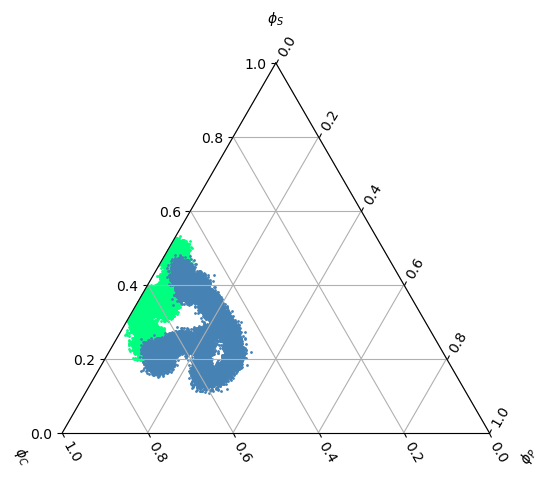

In [75]:
my_input = np.array([1,1,100,-10,-1,-1])
my_output = model.predict(my_input.reshape(1,6))
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (my_output[0][:,0], my_output[0][:,2], my_output[0][:,1], color='springgreen'  , s=1)
ax.scatter (my_output[0][:,3], my_output[0][:,5], my_output[0][:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

1/1 [==============================] - 0s 31ms/step


/var/folders/gn/nzb5h_193xs6scmlhvpn67txypqxcp/T/ipykernel_39615/3216929045.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


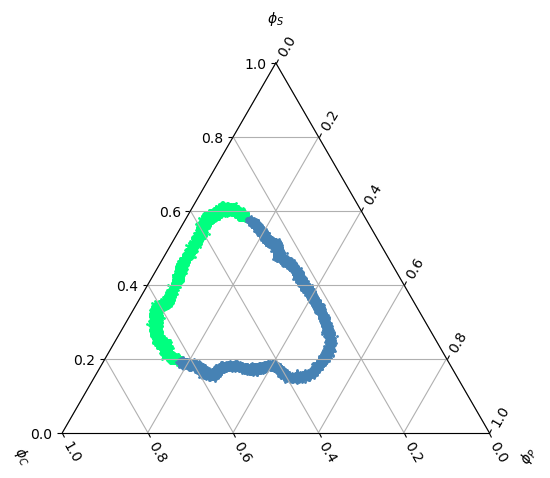

In [74]:
my_input = np.array([1,1,20,-10,-1,-1])
my_output = model.predict(my_input.reshape(1,6))
fig = plt.figure()
ax  = fig.add_subplot(projection="ternary")
ax.scatter (my_output[0][:,0], my_output[0][:,2], my_output[0][:,1], color='springgreen'  , s=1)
ax.scatter (my_output[0][:,3], my_output[0][:,5], my_output[0][:,4], color='steelblue', s=1)
ax.set_tlabel("$\\phi _{S}$")
ax.set_llabel("$\\phi _{C}$")
ax.set_rlabel("$\\phi _{P}$")
ax.set_tlim(0,1)
ax.set_llim(0,1)
ax.set_rlim(0,1)
positions = ["tick1", "tick2"]
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)
ax.grid ()
fig.show()

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 240000)            61680000  
                                                                 
 reshape (Reshape)           (None, 40000, 6)          0         
                                                                 
Total params: 61,721,792
Trainable params: 61,721,792
Non-tra